In [1]:
import pytest
import ipytest
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from test.model.port_schema import Portfolio
from util import data

ipytest.autoconfig()

%matplotlib inline

plt.style.use('ggplot2')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
class TestPortfolioAssess:
    def perform_analysis(self, syms, sd, ed, wts, sv, rfr=0.0, sf=252.0, show=False):
        """
        Performs the portfolio analysis and returns various statistical metrics.

        Parameters:
        -----------
            syms: symbol tickers
            sd: start date
            ed: end date
            wts: portfolio weights for the symbols
            sv: starting portfolio value
            rfr: risk free rate
            sf: sampling frequency per year
            show: show plot or not
            
        Returns:
        --------
            cr: cumulative return
            adr: average daily return
            sddr: standard deviation of daily return
            sr: sharpe ratio
            ev: ending portfolio value
        """
        # -----------------------------
        # Step 1: Daily Portfolio Value
        # -----------------------------
        
        # get symbol price data for the dates between sd and ed both included
        dates = None
        if sd and ed:
            dates = pd.date_range(sd, ed)
        prices_all = data.get_data(syms, dates)  # automatically adds SPY
        #
        # forward fill should be done before backward fill
        prices_all.ffill(inplace=True)
        prices_all.bfill(inplace=True)
        #
        prices = prices_all[syms]  # only portfolio symbols
        prices_SPY = prices_all['SPY']  # only SPY, for comparison later
        #
        # get normalized prices to bring all at 1 on the initial day
        normed = prices/prices.values[0]
        #
        # scale the allocation of syms assets as per their weightage in the portfolio
        alloced = normed.multiply(wts)
        #
        # get the daily individual asset values based on the starting investment in the portfolio
        pos_vals = alloced.multiply(sv)
        #
        # get the daily portfolio value
        port_val = pos_vals.sum(axis=1)
        
        # ----------------------------
        # Step 2: Portfolio Statistics
        # ----------------------------

        # daily return
        dr = ( port_val / port_val.shift(1) ) - 1
        #
        # cumulative return
        cr = ( port_val.iloc[-1] / port_val.iloc[0] ) - 1
        #
        # average daily return
        adr = dr.mean()
        #
        # std of daily return
        sddr=dr.std()
        #
        # adjustment factor
        k = np.sqrt(sf)
        #
        # sharpe ratio <=> risk adjusted return
        sr = k * ( dr.subtract(rfr).mean() / sddr )
        #
        # end value of the portfolio
        ev = port_val.iloc[-1]
        
        # -------------------------
        # Step 3: Optional Plotting
        # -------------------------
        
        # Compare daily portfolio value with SPY using a normalized plot
        if show:
            # normalized daily portfolio value
            port_val = port_val / port_val.iloc[0]
            #
            # normalized daily SPY value (benchmark)
            prices_SPY = prices_SPY / prices_SPY.iloc[0]
            #
            # join dataframes along the columns for plotting
            df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
            #
            # plot the data
            data.plot_data(df_temp, title='Daily portfolio value and SPY')
        
        return cr, adr, sddr, sr, ev

    def print_conf(self, portfolio):
        print(portfolio.description, '='*30, sep='\n')
        print(f'Symbols: {portfolio.symbols}')
        print(f'Weights: {portfolio.weights}')
        print(f'Start date: {portfolio.start_date}')
        print(f'End date: {portfolio.end_date}')
        print(f'Initial value: {portfolio.initial_value}')
        print('-'*30)
        
    def print_stats(self, cr, adr, sddr, sr, ev):
        print(f'Cumulative return: {cr:.3f}')
        print(f'Average daily return: {adr:.3f}')
        print(f'Standard deviation of daily return: {sddr:.3f}')
        print(f'Sharpe ratio: {sr:.3f}')
        print(f'Portfolio final value: {ev:.0f}')
        print()
    
    @pytest.mark.parametrize(
        'port_test_conf',
        [
            'prj1_port_data_1.yaml',
            'prj1_port_data_2.yaml',
            'prj1_port_data_3.yaml',
        ],
        indirect=True
    )
    def test_portfolios(self, portfolio):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=DeprecationWarning)
            cr, adr, sddr, sr, ev = self.perform_analysis(
                portfolio.symbols, portfolio.start_date, portfolio.end_date,
                portfolio.weights, portfolio.initial_value, show=True
                )
            self.print_conf(portfolio)
            self.print_stats(cr, adr, sddr, sr, ev)

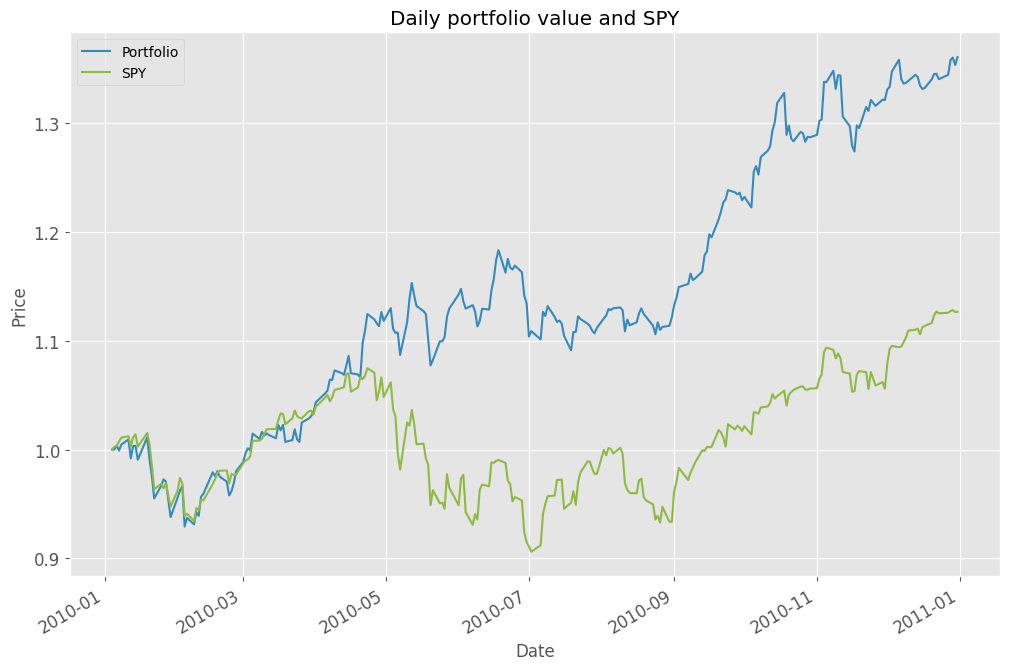

Test Portfolio 1
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Weights: [0.0, 0.4, 0.6, 0.0]
Start date: 2010-01-01
End date: 2010-12-31
Initial value: 100000
------------------------------
Cumulative return: 0.361
Average daily return: 0.001
Standard deviation of daily return: 0.010
Sharpe ratio: 2.004
Portfolio final value: 136090

.

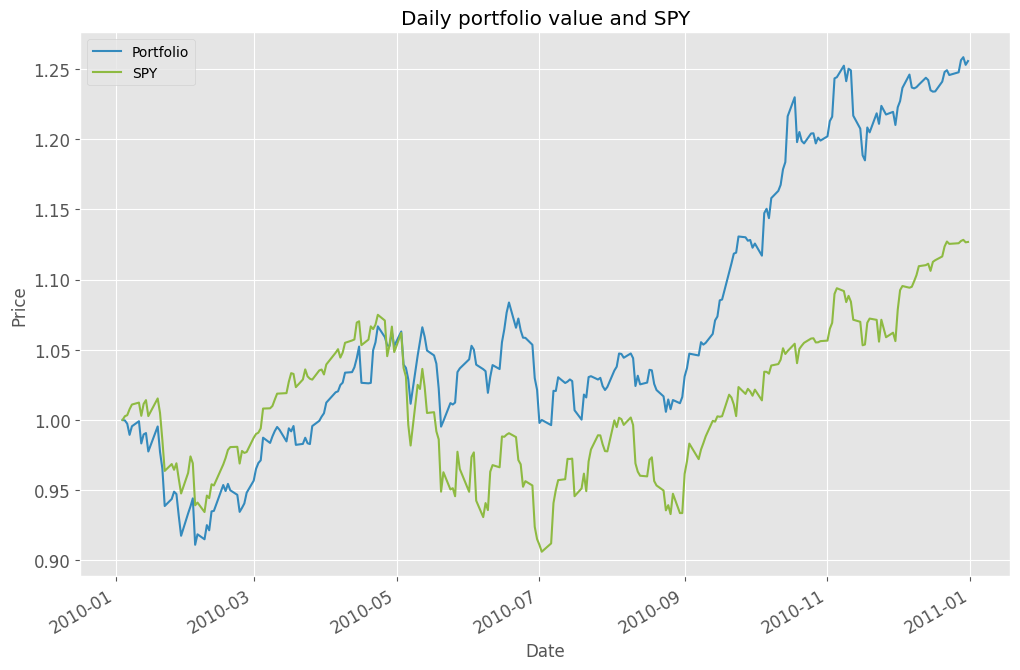

Test Portfolio 2
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Weights: [0.2, 0.3, 0.4, 0.1]
Start date: 2010-01-01
End date: 2010-12-31
Initial value: 100000
------------------------------
Cumulative return: 0.256
Average daily return: 0.001
Standard deviation of daily return: 0.010
Sharpe ratio: 1.518
Portfolio final value: 125565

.

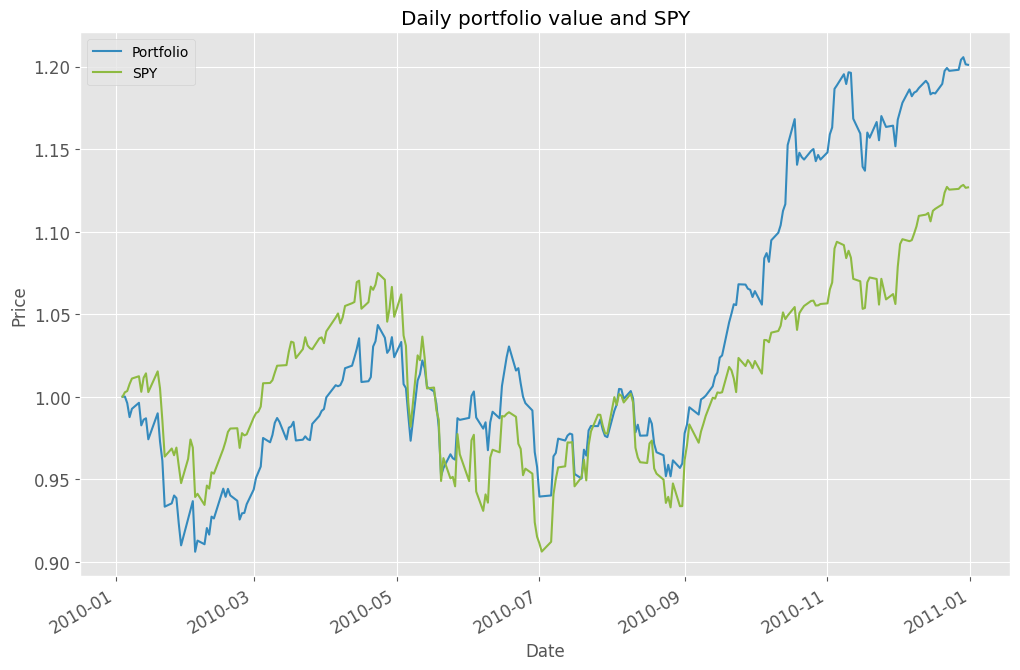

Test Portfolio 3
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Weights: [0.25, 0.25, 0.25, 0.25]
Start date: 2010-01-01
End date: 2010-12-31
Initial value: 100000
------------------------------
Cumulative return: 0.201
Average daily return: 0.001
Standard deviation of daily return: 0.010
Sharpe ratio: 1.208
Portfolio final value: 120106

.


<ExitCode.OK: 0>

In [3]:
ipytest.run('-qs', '--rootdir=../../')

---